# Physics-informed neural networks for the solution of 1 dimensional equations

In [1]:
# Set the correct search path for importing packages
import sys
sys.path.insert(1, '../PINNLearning')
# Surpress unnecessary output from tensorflow package
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import necessary functions/ packages
from training import learning_rate_schedule, train, oneD_loss
from data import gen_data, set_boundaries, simp_sol, simp_sim
from models import create_model
import matplotlib.pyplot as plt
import keras

We first need to set some global values and settings:

In [2]:
# Plot settings
plt.close('all')
plt.rcParams['font.family'] = 'Ubuntu Nerd Font'
plt.rcParams['font.size'] = 10

# Dimensions of the simulation space
lower_bound = 0.0
upper_bound = 1.0

## Initial Testing with boundary conditions

We try to solve the heat equation:

$\dfrac{\partial u(x, t)}{\partial t} = \alpha \cdot \Delta u(x, t)$

For this we intially set some simplifications:
* The diffusion factor $\alpha$ is set to 1
* The function is not dependend on the time: $u(x, t) = u(x)$
* The function is only 1 dimensional: $\Delta u(x, t) = \frac{d^2 u(x, t)}{d^2x}$


With these simplifications the upper equation results to:

$u(x) = \dfrac{d^2}{dx^2} u(x)$

With the dirichlet boundary conditions set to:

$u(0) = 1$ and $u(1) = 0$

It is easily possible adjust these and to change them to Neumann boundary conditions, by adjusting the loss function used for trainging the PINN.

For comparative purposes, the here described boundaries result in the following analytical solution for this equation:

$u(x) = \dfrac{e^{-x} (e^2-e^{2x})}{e^2-1}$

As the model will be created using Tensorflow (Tf), all data that is entered into (or is returned from) the model must be in the format of a Tf tensor.
For this, the boundary conditions first need to be converted to a tensors.

Because the differential equation fully describes our problem and (enough) boundary conditions are given, we can adopt an unsupervied learning regime (data points only entail an x value, no correct y value).
In line with this, the training data can just be (by choice also randomly) generated accross the problem space from above but must be ultimately converted to a Tf tensor.
The dimenions of this tensor are important as Tf automatically generates the input layer of the neural network from this. Tf uses the _„row-major“_ storage format, thereby every **row** is a seperate data point and every **column** is a seperte input feature.


When creating the model, a lot of hyperparameters, such as the learning rate, the number of epochs (alternatively here the minimal loss-improvement threashold) or the dimensions of the network itself, can be adjusted.
For simple problems like this one, this is mostly not necessary. However, for larger and more resource intensive problems it can be vital to boost the performance. An examplery implementation of such an Hyperparameter Optimizaion (HPO) Algorithm together with an Neural Architectur Search (NAS) Algorithm can be found in the `HPO & NAS` notebook.
For these initiall problems we do without it.
In some cases, e.g. the learning rate, a dynamic change over the course of the trainig time can help with the convergence of the algorithm. This is called Dynamic Algorithm Configuration (DAC), implemented here as a learning rate schedule.
Finding the best start/stop/step values can be seen mostly as an seperate Reinforcement Learning task. However, diverse heuristics have been formulated that should perform sufficiantly well for many problems.


Furthermore, for all implementations here it first checks if the model is already trained and entailed in the subdirectory `data`. If this is the case, the (re)training will be suspendend (but can be manually forced). Otherwise the model will be automatically trained and a loss-time development graph will be printed.

Epoch 100: Loss = 0.16201210021972656
Epoch 200: Loss = 0.0051771653816103935
Epoch 300: Loss = 0.0028757965192198753
Epoch 400: Loss = 0.002150318119674921
Epoch 500: Loss = 0.0016654926585033536
Epoch 600: Loss = 0.0013086318504065275
Epoch 700: Loss = 0.0010385094210505486
Epoch 800: Loss = 0.0008295289007946849
Epoch 900: Loss = 0.0006652768352068961
Epoch 1000: Loss = 0.000534886377863586
Epoch 1100: Loss = 0.00043067557271569967
Epoch 1200: Loss = 0.00034683282137848437
Epoch 1300: Loss = 0.0002787812554743141
Epoch 1400: Loss = 0.00022295971575658768
Epoch 1500: Loss = 0.00017669374938122928
Epoch 1600: Loss = 0.00013809734082315117
Epoch 1700: Loss = 0.00010589877638267353
Epoch 1800: Loss = 7.92769351392053e-05
Epoch 1900: Loss = 5.76698912482243e-05
Epoch 2000: Loss = 4.061694926349446e-05
Epoch 2100: Loss = 2.7644355213851668e-05
Epoch 2200: Loss = 1.8199127225670964e-05
Epoch 2300: Loss = 1.165172488981625e-05
Epoch 2400: Loss = 7.342230219364865e-06
Epoch 2500: Loss = 4.64

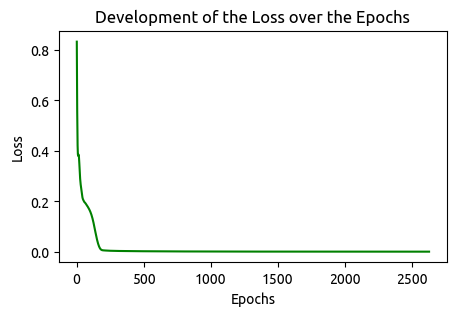

In [8]:
# Set the boundary conditions
x_bc, y_bc = set_boundaries([[0.0], [1.0]], [[1.0], [0.0]])

# Create the training data
x_train = gen_data(lower_bound, upper_bound, 100)

# Create the model with fixed sizes
model = create_model(3, 50)

# Create a learning rate schedule
# The purpose of which is to make learning more robust and increase speed
lr_schedule = learning_rate_schedule(1e-3, 1000, 0.9)

# Train the model if it is not already trained
try:
    # To force retraining of the model uncomment follwing line
    raise Exception

    model = keras.models.load_model('../data/simp_initial.keras')
except Exception as e:
    error_time = train(model, x_train, x_bc, y_bc, oneD_loss, lr_schedule, threshold=1e-8)
    model.save('../data/simp_initial.keras')

    # Create a graph showing the loss vs the epochs
    x, y = zip(*error_time)
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, 'g-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Development of the Loss over the Epochs')
    plt.show()

When the model is finished training, it needs to be tested against a more general case (called validation).
For this purpose, more data points must be gernerated and evaluated accross the problem space – the points that the model was trained on **CAN NOT** be part of this set!
Although this practice is more important for models that are required to deliver good gerneral performance (which is obviously not the case for models that return the specifc solution to an equation), it is still a good indicator if the model has properly trained on the data.

As can probably be seen here the loss over this validation data set will often be greater than the final training loss. As long as the difference is not orders of magnitudes, this still indicates a good performing model.

For further testing of the resulting model, the analytical solution is also inferenced accorss the validation data set. A graphical comparison is presented below.

The loss over the validation data is: 1.4743586689291988e-05


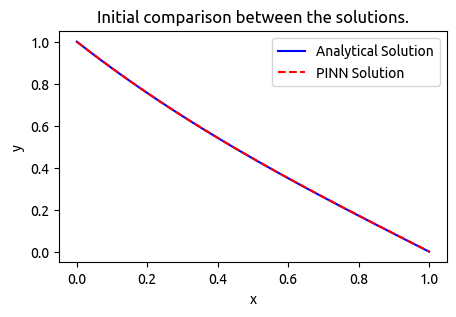

In [ ]:
x_test = gen_data(lower_bound, upper_bound, 1000)

# Calculate the loss over the test data
val_loss = oneD_loss(model, x_test, x_bc, y_bc)
print(f"The loss over the validation data is: {val_loss}")

# Convert the returned Tf tensor to numpy for plotting
y_pred = model(x_test).numpy()
y_true = simp_sol(x_test)

plt.figure(figsize=(5, 3))
plt.plot(x_test, y_true, 'b-', label="Analytical Solution")
plt.plot(x_test, y_pred, 'r--', label='PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Initial comparison between the solutions.')
plt.show()

## Initial Equation without boundary conditions

In some situations (typically more practical applications), the differential equations fully describing the problem can not be found or not all necessary boundary conditions are given.
However, as long as governing equations can be formulated this situation can still be solved.

For this purpose, the loss function needs to be adjusted to incorporate **real world mesurement data**. 

This however, also introduces the problem of noice in the traing data and must be done carfully.

In the simplified problem from above, this situation is imitated by removing the boundary conditions and switching to a supervised learning regime (all data points now contain an x- and an y-value).

The "measured" training data is gathered by sampling the y-values once from the analytic solution (no noice in the data – ideal measurements) and once from an iterative finite-differences based simulation (noicy measurements). Both follow from the previously generated x-values in the training data set. A comparison between these is shown below.

In this case we will not be using a validaten data set, as the simulation can not handle the enlarged number of data points in an appropriate time or with appropriate resources. This is by the way not a problem of the PINN, which constitutes the main reason why the utilisation of PINNs poses an intresting option.

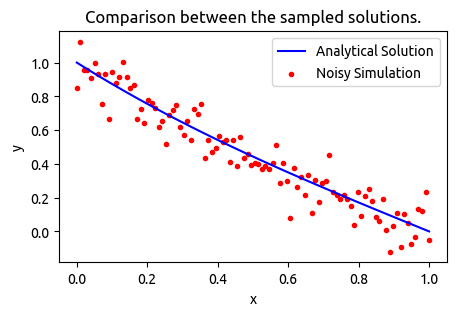

In [ ]:
# Simulate the measurement data by generating 
# the different y-Values for the training data
y_train_noisy = simp_sim(x_train, y_bc, noise_level=0.2)[1]
y_train_true = simp_sol(x_train)
# FYI: As the y-values are only used to compute the loss and
# are thus not directly entered into the PINN, they do not
# need to be a Tf tensor!


plt.figure(figsize=(5, 3))
plt.plot(x_train, y_train_true, 'b', label="Analytical Solution")
plt.scatter(x_train, y_train_noisy, c='r', label='Noisy Simulation', marker='.')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison between the sampled solutions.')
plt.show()

The training is just a repeat of the same from above. 
Although there is a slight abuse of the implementation here. As the loss over the boundary conditions is computed in the same way as the loss accross the trainig data, these data points are entered into the training function below as the "boundary conditions".

The process is repeated equivalently for both data sets.

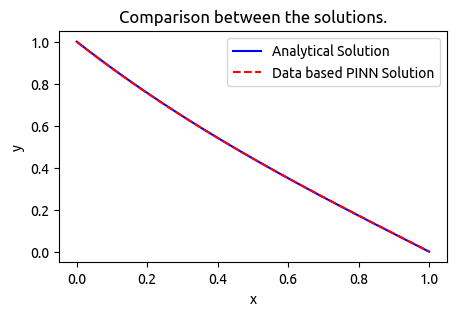

In [ ]:
# Create 2 models, one for each y-data
model2 = create_model(3, 50)
model3 = create_model(3, 50)


# Train the model for the true y-data if it is not already trained
try:
    # To force retraining of the model uncomment follwing line
    ## raise Exception

    model2 = keras.models.load_model('../data/simp_data_true.keras')
except Exception as e:
    error_time = train(model2, x_train, x_train, y_train_true, oneD_loss, lr_schedule, threshold=1e-8)
    model2.save('../data/simp_data_true.keras')

    # Create a graph showing the loss vs the epochs
    x, y = zip(*error_time)
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, 'g-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Development of the Loss over the Epochs')
    plt.show()


# Visually compare the model with the analytical solution
y_pred2 = model2(x_test).numpy()

plt.figure(figsize=(5, 3))
plt.plot(x_test, y_true, 'b-', label="Analytical Solution")
plt.plot(x_test, y_pred2, 'r--', label='Data based PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison between the solutions.')
plt.show()

Epoch 100: Loss = 0.013559301383793354
Epoch 200: Loss = 0.011118319816887379
Epoch 300: Loss = 0.009969419799745083
Epoch 400: Loss = 0.009336470626294613
Epoch 500: Loss = 0.009014853276312351
Epoch 600: Loss = 0.008809289894998074
Epoch 700: Loss = 0.008658098056912422
Epoch 800: Loss = 0.008537421934306622
Epoch 900: Loss = 0.00843650009483099
Epoch 1000: Loss = 0.008361009880900383
Epoch 1100: Loss = 0.008312031626701355
Epoch 1200: Loss = 0.008290736004710197
Last Epoch 1205: last Loss = 0.008289231918752193


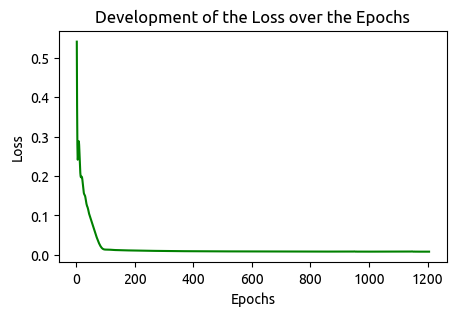

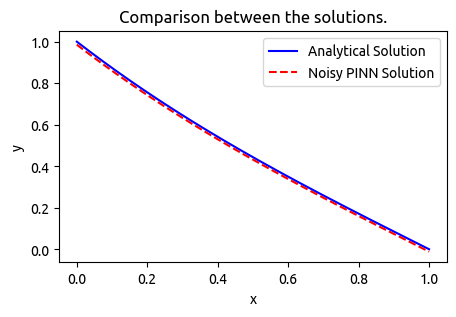

In [ ]:
# Train the model for the nosy y-data if it is not already trained
try:
    # To force retraining of the model uncomment follwing line
    ## raise Exception

    model3 = keras.models.load_model('../data/simp_data_noisy.keras')
except Exception as e:
    error_time = train(model3, x_train, x_train, y_train_noisy, oneD_loss, lr_schedule, threshold=1e-8)
    model3.save('../data/simp_data_noisy.keras')

    # Create a graph showing the loss vs the epochs
    x, y = zip(*error_time)
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, 'g-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Development of the Loss over the Epochs')
    plt.show()


# Visually compare the model with the analytical solution
y_pred3 = model3(x_test).numpy()

plt.figure(figsize=(5, 3))
plt.plot(x_test, y_true, 'b-', label="Analytical Solution")
plt.plot(x_test, y_pred3, 'r--', label='Noisy PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison between the solutions.')
plt.show()

It is obvious that the PINN trained on the ideal data perfectly models the analytical solution. Therefore, it is clear, that using this option, missing parts of the differential equation or the boundary conditions can be successfully substituted.


It can also be seen, that the model trained with the noisy data still properly learned the function. Playing around with the amount of noise added to the data above, this holds true for **all** configurations.
This follows from the choice of the loss-term as mean squarred error and the centering of the noise around the true value. For this reason it is important that all measurements are accurate (but not necessarily precise, allowing for e.g. random noise) and thus the absence of e.g. offset errors can be guaranteed.


Comparing both resulting models, in the very most cases the one trained on the noisy data demonstrates a larger remaining error value. This should improve in tendency with increasing the number of data points. However, the increased accuracy of the model must obviously be balanced against the effort of taking the additional measurements.


As such it is important to consider the error in the "predicted" values inferenced from the PINN for further use.

In [ ]:
# Compute some numbers for comparison between these methods

err2 = y_true - y_pred2
err3 = y_true - y_pred3

avg2 = abs((sum(err2)/len(err2))[0])
max2 = max(abs(err2))[0]

avg3 = abs((sum(err3)/len(err3))[0])
max3 = max(abs(err3))[0]

sign1 = '>' if avg2 > avg3 else '<'
sign2 = '>' if max2 > max3 else '<'

print(20*" " + "True Solution" + 10 * " " + "Noisy Solution")
print(f"Average Error: {avg2}" + " " + sign1 + f" {avg3}")
print(f"Maximum Error: {max2}" + 2*" " + sign2 + f" {max3}")

                    True Solution          Noisy Solution
Average Error: 0.00017382833175361156 < 0.012157093733549118
Maximum Error: 0.0012981281615793705  < 0.014592289924621582
